# Load data using dataframe.

% pip install neurokit2

conda install conda-forge::neurokit2

In [285]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn import tree


from sklearn.model_selection import cross_val_score

# import graphviz


import os

In [286]:

def convert_units(data):
    eda = (data / 2**10) * 3.3 / 0.12
    return eda


In [287]:
# Load data in file Data/Session_3.csv into a pandas dataframe

# Load data from file

datadir = os.path.join('..', 'data')

dataKagan = pd.read_csv(os.path.join(datadir, 'session_Test_01.csv'))
dataNeja = pd.read_csv(os.path.join(datadir, 'session_neja.csv'))
dataSets = [dataNeja]

data = pd.concat(dataSets, ignore_index=True)


# Sampling freq.
fs = 1000



In [288]:

# Display the data
data.head()

,Time,Resp,ECG,EDA,Trigger
0,0.000,513.0,552.0,9.077148,-1.0
1,0.001,513.0,546.0,9.077148,-1.0
2,0.002,512.0,543.0,9.077148,-1.0
3,0.003,512.0,536.0,9.077148,-1.0
4,0.004,512.0,531.0,9.077148,-1.0


In [289]:
# get unique triggers
triggers = data['Trigger'].unique()

# print the unique triggers
print("Unique triggers:", triggers)

Unique triggers: ['-1.0' 'q' 't' 'f']


In [290]:
data['EDA'] = convert_units(data['EDA'])


In [291]:
from scipy.signal import detrend

# remove mean and trend from Resp
data['Resp'] = detrend(data['Resp'])

# Trigger management
Transform p into -1 , and remove excess of 0 and 1

In [292]:
# change value in position i in Trigger column to -1.0 if the value in  sample i-1 was 'p', '0', or '1'



# Create a list of the indexes of the rows that need to be changed
#indexes_to_change = []
#for i in range(1, len(data)):
 #   if data.loc[i-1, 'Trigger'] in ['q', 't', 'f']:
  #      indexes_to_change.append(i)

# Change the values in the Trigger column
#data.loc[indexes_to_change, 'Trigger'] = '-1.0'

# change p in Trigger column to -1.0
data.loc[data['Trigger'] == 'q', 'Trigger'] = '-1.0'

# change t in Trigger column to 1.0
data.loc[data['Trigger'] == 't', 'Trigger'] = '1.0'

# change f in Trigger column to 0.0
data.loc[data['Trigger'] == 'f', 'Trigger'] = '0.0'


# Convert the values in the Trigger column to float
data['Trigger'] = data['Trigger'].astype(float)

# get trigger values above -1
trigger_values = data[data['Trigger'] > -1.0]['Trigger']


print(len(trigger_values))



18


In [293]:
trigger_values

40000      1.0
95000      1.0
151000     0.0
215000     1.0
269000     0.0
328000     1.0
383000     1.0
440000     0.0
498000     0.0
562000     1.0
623000     1.0
685000     1.0
742000     0.0
803000     0.0
859000     1.0
932000     0.0
1001000    1.0
1062000    1.0
Name: Trigger, dtype: float64

# Data visualization

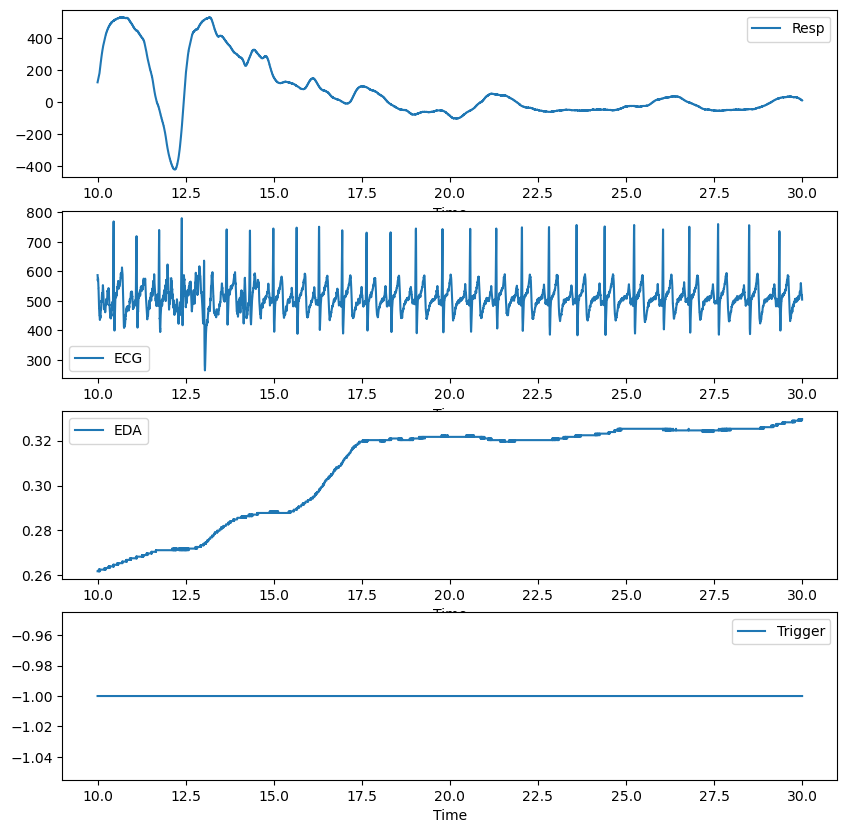

In [294]:
# plot the data, x-axis is the first column, subplots for the second, third and fourth column

offset=10000
wSize=20000

# figure with 3 subplots only show 10 seconds of data
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# plot the data
data.iloc[offset:offset+wSize].plot(x='Time', y='Resp', ax=axs[0])
data.iloc[offset:offset+wSize].plot(x='Time', y='ECG', ax=axs[1])
data.iloc[offset:offset+wSize].plot(x='Time', y='EDA', ax=axs[2])
data.iloc[offset:offset+wSize].plot(x='Time', y='Trigger', ax=axs[3])

# show the plot
plt.show()



# Extract epochs

In [295]:
# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples
ePreSize= 4*fs
ePosSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(data.iloc[indices[i]-ePreSize:indices[i]+ePosSize])

num_epochs = len(epochs)
print(num_epochs)


18


# Resp features.

In [ ]:
from scipy.signal import find_peaks

# compute average of segments
rMean = []
rSD = []
rMax = []
rMin = []
rUnderCurve = []
rResp_rate_variability = []
rBreath_hold_ratio = []

for ep in epochs:
    rMean.append(ep['Resp'][ePreSize:].mean()/ep['Resp'][:ePreSize].mean())
    rSD.append(ep['Resp'][ePreSize:].std()/ep['Resp'][:ePreSize].std())
    rMax.append(ep['Resp'][ePreSize:].max()/ep['Resp'][:ePreSize].max())
    rMin.append(ep['Resp'][ePreSize:].min()/ep['Resp'][:ePreSize].min())
    
    # Added
    rUnderCurve.append(np.trapz(ep['Resp'][ePreSize:])/np.trapz(ep['Resp'][:ePreSize]))
    
    # respiratory rate variability
    peaks, _ = find_peaks(ep['Resp'][ePreSize:], distance=fs//2)
    if len(peaks) > 1:
        intervals = np.diff(peaks) / fs  # Intervaly mezi náddechy
        rrv = np.std(intervals) / np.mean(intervals)  # Koeficient variace
        rResp_rate_variability.append(rrv)
    else:
        rResp_rate_variability.append(0)
        
    # Breath hold detection
    post_resp = ep['Resp'][ePreSize:]
    # Najít oblasti s minimální aktivitou
    low_activity = np.abs(post_resp) < np.std(post_resp) * 0.3
    hold_ratio = np.sum(low_activity) / len(post_resp)
    rBreath_hold_ratio.append(hold_ratio)



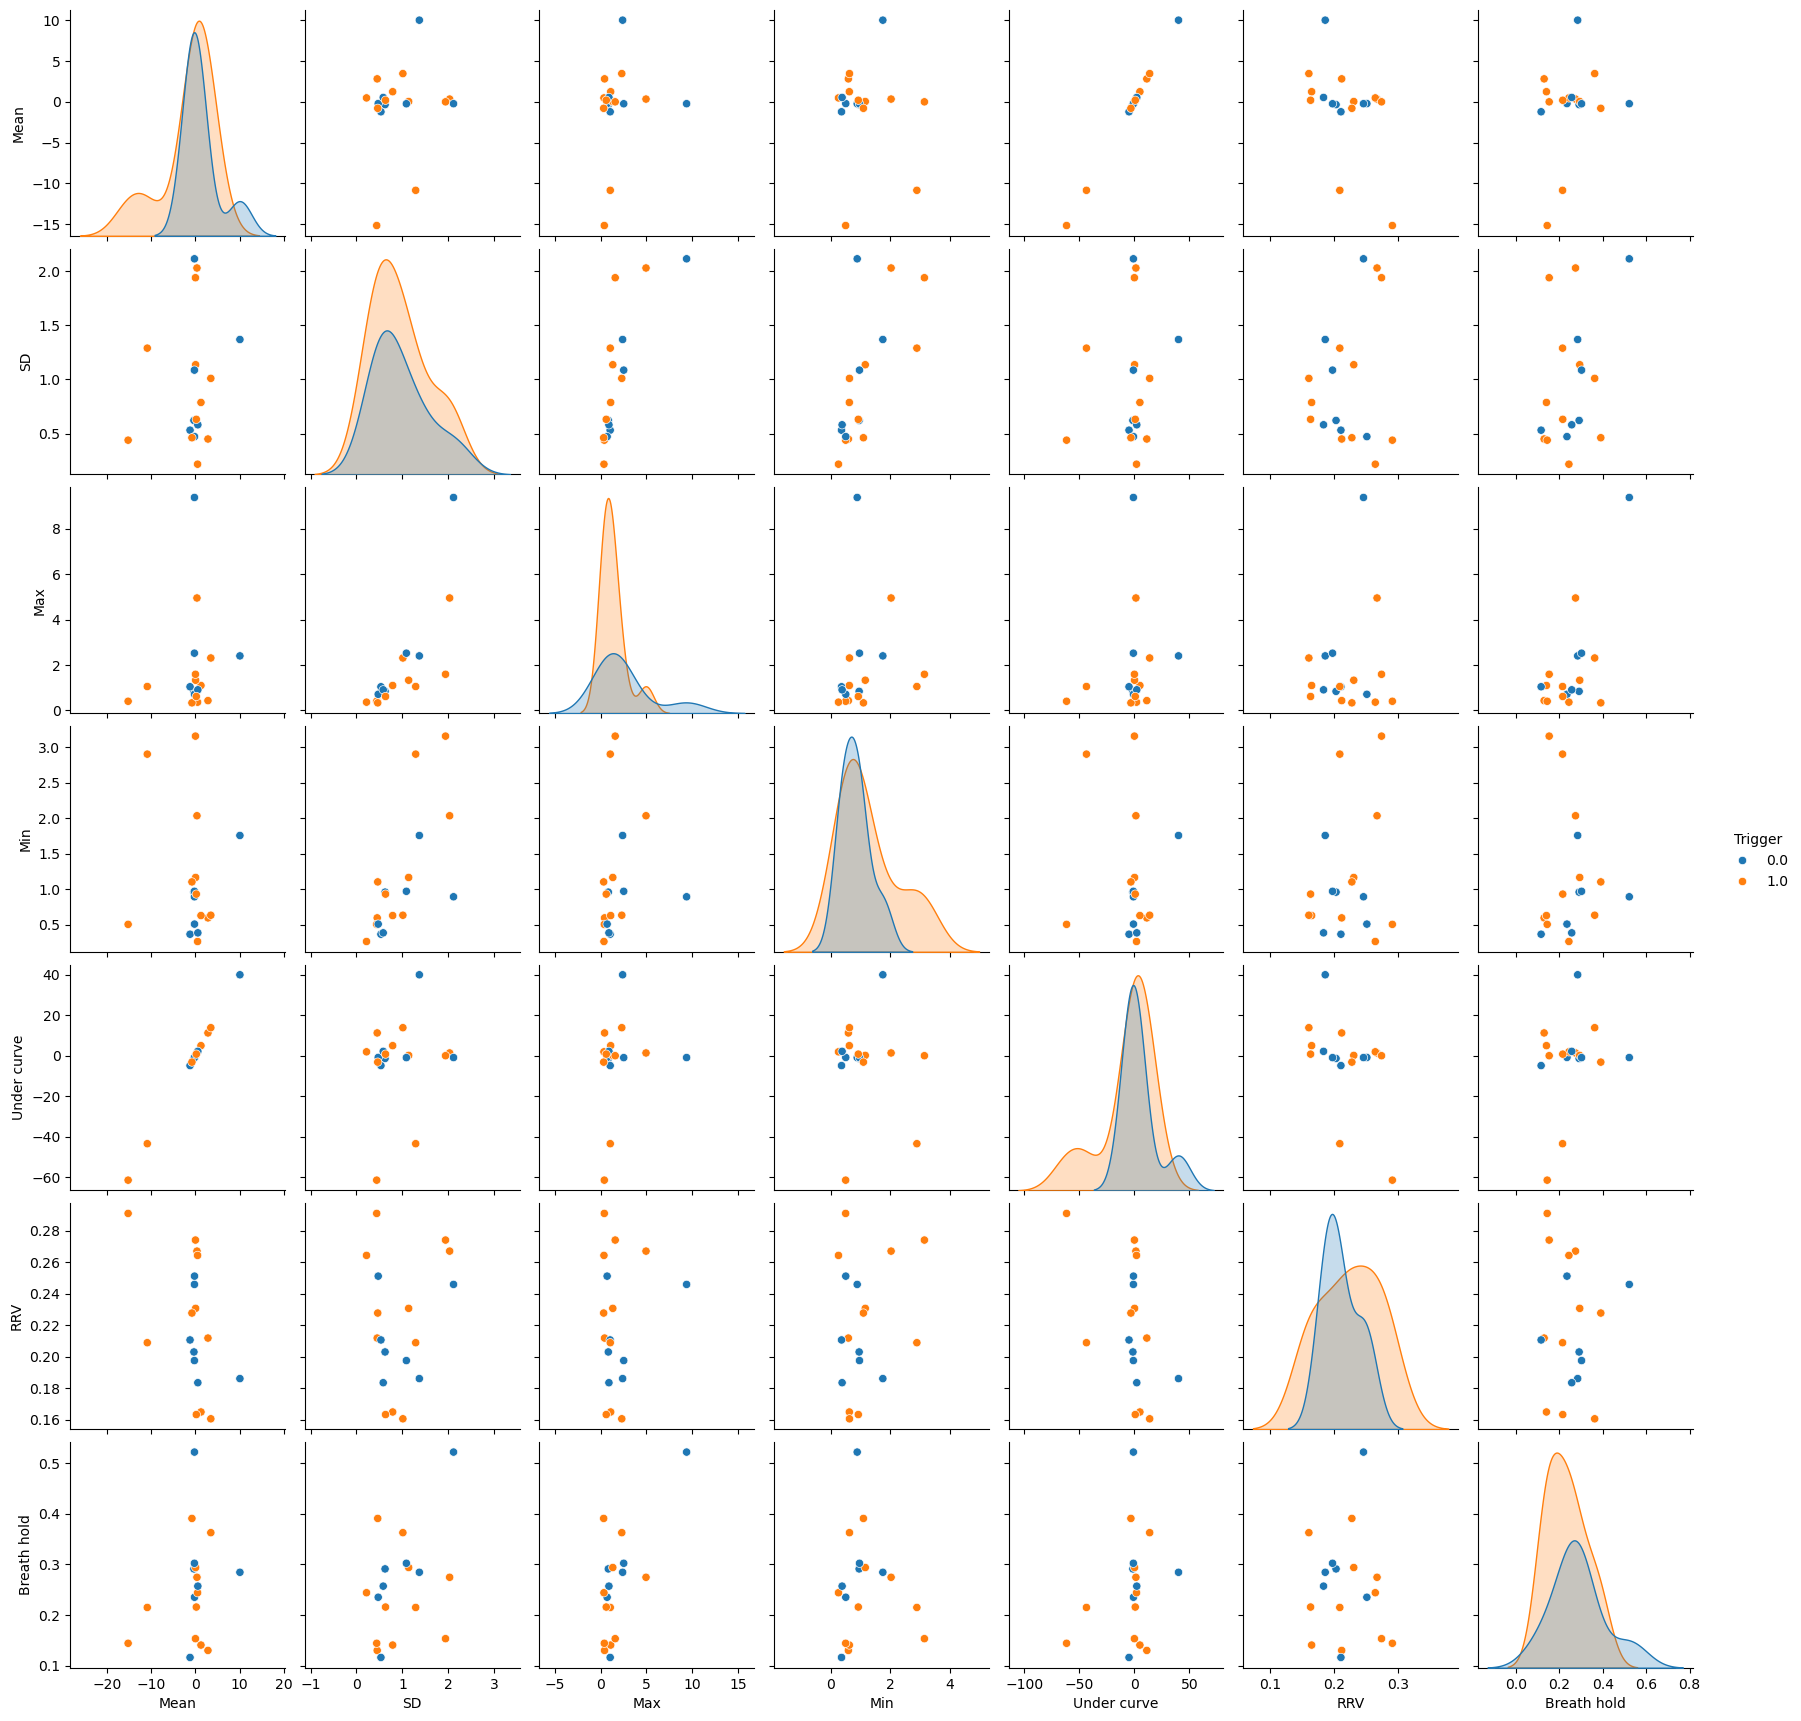

In [297]:
# show feature  grouped by trigger_values 0 and 1 using seaborn
df = pd.DataFrame({'Mean': rMean, 'SD': rSD, 'Max': rMax, 'Min': rMin, 'Trigger': trigger_values, 'Under curve': rUnderCurve, 'RRV':rResp_rate_variability, 'Breath hold': rBreath_hold_ratio})

sns.pairplot(df, hue='Trigger')
plt.show()

# EDA features.

In [298]:

# Load data from file
eda = data['EDA']

# compute the EDA features
eda_features = nk.eda_process(eda, sampling_rate=1000)


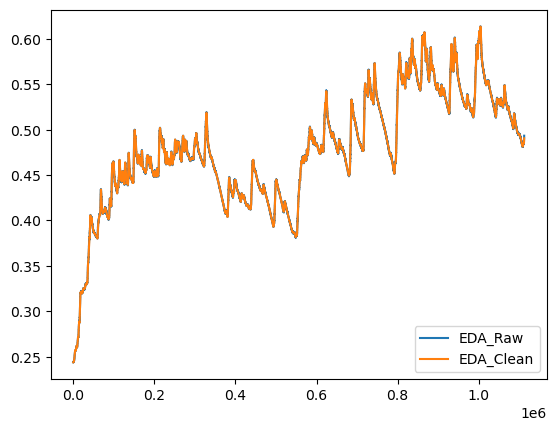

In [299]:
eda_features[0]['EDA_Raw'].plot()
eda_features[0]['EDA_Clean'].plot()
plt.legend(loc="lower right")
plt.show()


In [300]:


# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples

preSize= 4*fs
posSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(eda_features[0].iloc[indices[i]-preSize:indices[i]+posSize])

num_epochs = len(epochs)
print(num_epochs)



18


In [301]:
# compute average of segments
edaMean = []
edaSD = []
edaMax = []
edaMin = []
eUnderCurve = []


for ep in epochs:
    edaMean.append(ep['EDA_Clean'][preSize:].mean()/ep['EDA_Clean'][:preSize].mean())
    edaSD.append(ep['EDA_Clean'][preSize:].std()/ep['EDA_Clean'][:preSize].std())
    edaMax.append(ep['EDA_Clean'][preSize:].max()/ep['EDA_Clean'][:preSize].max())
    edaMin.append(ep['EDA_Clean'][preSize:].min()/ep['EDA_Clean'][:preSize].min())
    eUnderCurve.append(np.trapz(ep['EDA_Clean'][ePreSize:])/np.trapz(ep['EDA_Clean'][:preSize]))

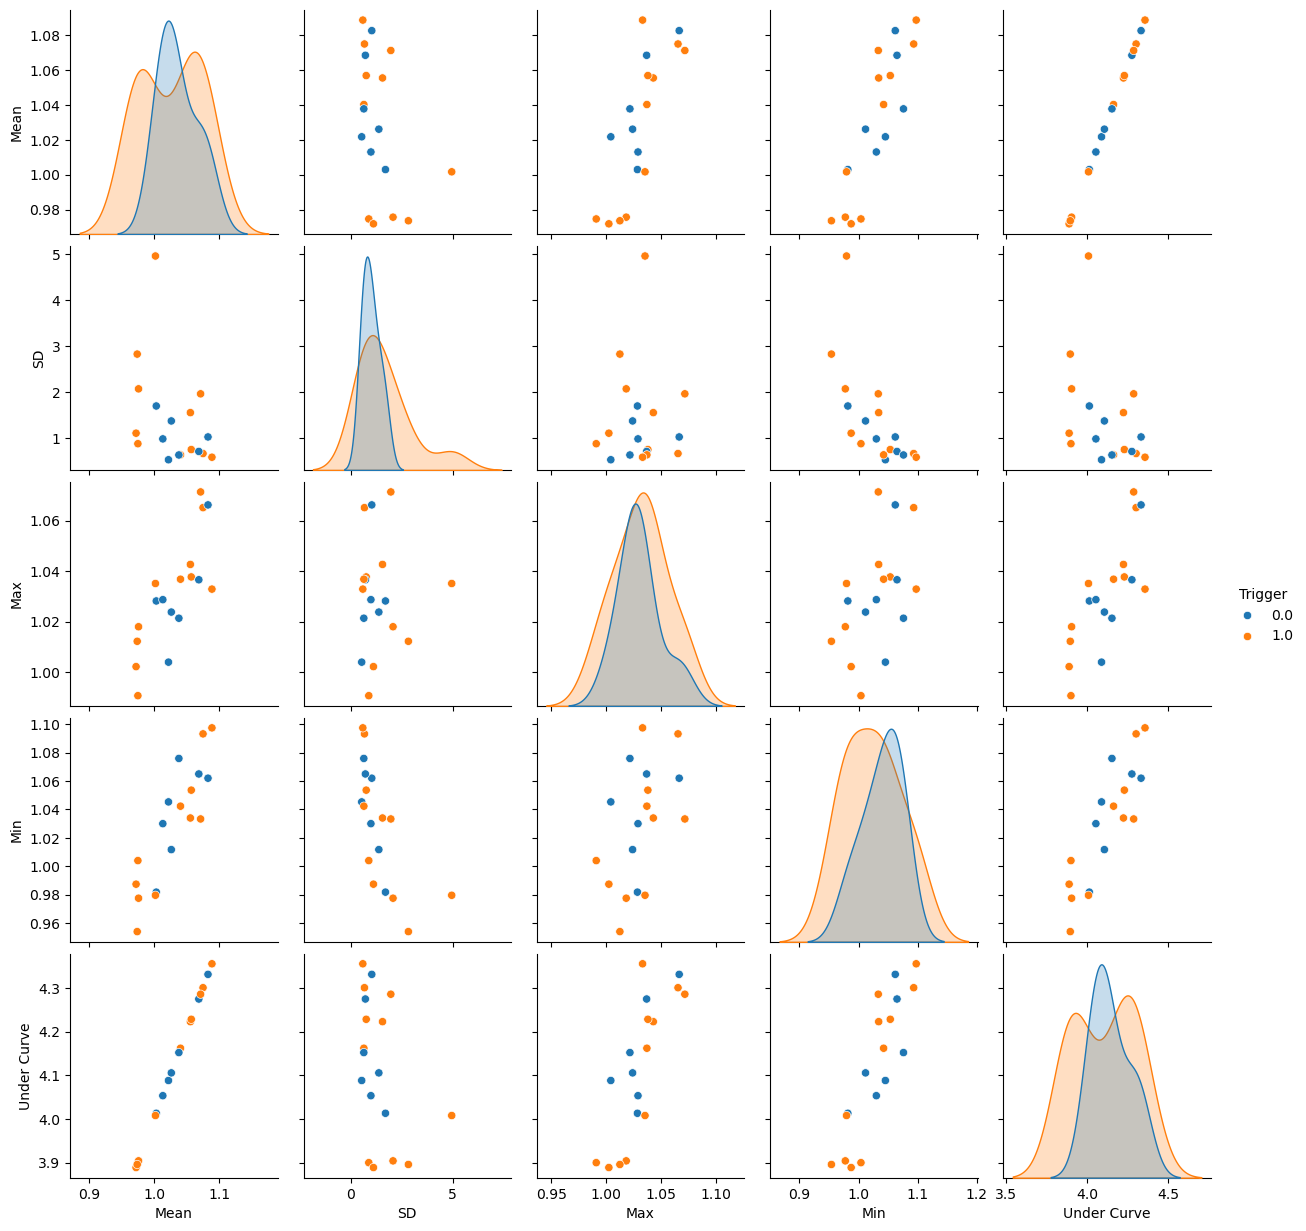

In [302]:
# show feature  grouped by trigger_values 0 and 1 using seaborn
df = pd.DataFrame({'Mean': edaMean, 'SD': edaSD, 'Max': edaMax, 'Min': edaMin, 'Trigger': trigger_values, 'Under Curve': eUnderCurve})

sns.pairplot(df, hue='Trigger')
plt.show()

# ECG

In [303]:
ecg_cleaned = nk.ecg_clean(data['ECG'], sampling_rate=1000)

instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
_, waves_peak = nk.ecg_delineate(data['ECG'], rpeaks, sampling_rate=1000, method="peak")

rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


# Prepare output
signals = pd.DataFrame({"ECG_Raw": data['ECG'],
                        "ECG_Clean": ecg_cleaned,
                        "ECG_Rate": rate,
                        "ECG_Quality": quality})


signals = pd.concat([signals, instant_peaks], axis=1)

/home/bert/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


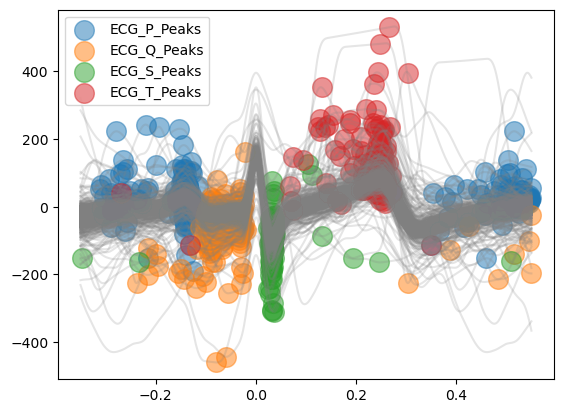

In [304]:
signal_dwt, waves_dwt = nk.ecg_delineate(signals,
                                        rpeaks,
                                        sampling_rate=1000,
                                        method="dwt",
                                        show=True,
                                        show_type='peaks')

In [305]:
epochs=[]

# Process the data for event-related analysis
df, info = nk.bio_process(ecg=signals['ECG_Clean'], sampling_rate=1000)


events = nk.events_find(data["Trigger"], threshold=-1.0, event_conditions=trigger_values.values, threshold_keep='above')

epochs = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=-1.0, epochs_end=7.0)

# Analyze
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=1000)


/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:133: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` o

In [306]:
# print(epochs['1'])

for epKey in epochs.keys():
    print(epochs[epKey])
# print(epochs)

           ECG_Raw  ECG_Clean   ECG_Rate  ECG_Quality  ECG_R_Peaks  Index  \
-1.000000    484.0 -23.238364  78.712712     0.991590            0  39000   
-0.999000    486.0 -22.669274  78.710896     0.991624            0  39001   
-0.998000    487.0 -22.105195  78.709082     0.991659            0  39002   
-0.997000    488.0 -21.548625  78.707271     0.991693            0  39003   
-0.995999    489.0 -21.002064  78.705462     0.991727            0  39004   
...            ...        ...        ...          ...          ...    ...   
 6.995999    500.0  -8.282719  81.321829     0.978019            0  46995   
 6.997000    497.0 -11.214293  81.321213     0.978027            0  46996   
 6.998000    493.0 -14.060854  81.320595     0.978036            0  46997   
 6.999000    491.0 -16.814902  81.319975     0.978045            0  46998   
 7.000000    488.0 -19.473939  81.319353     0.978054            0  46999   

          Label  Condition  
-1.000000     1        1.0  
-0.999000     1  

In [307]:
test = epochs['1']['ECG_Clean']
df, _ = nk.bio_process(test, sampling_rate=1000)
df

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-23.238364,-7.673540,81.543898,1.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
1,-22.669274,-7.229195,81.543898,1.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
2,-22.105195,-6.786375,81.543898,1.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
3,-21.548625,-6.346571,81.543898,1.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
4,-21.002064,-5.911244,81.543898,1.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-8.282719,48.671264,81.411126,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7996,-11.214293,46.449640,81.411126,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7997,-14.060854,44.231778,81.411126,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0
7998,-16.814902,42.017004,81.411126,0.0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,NaN,0.0


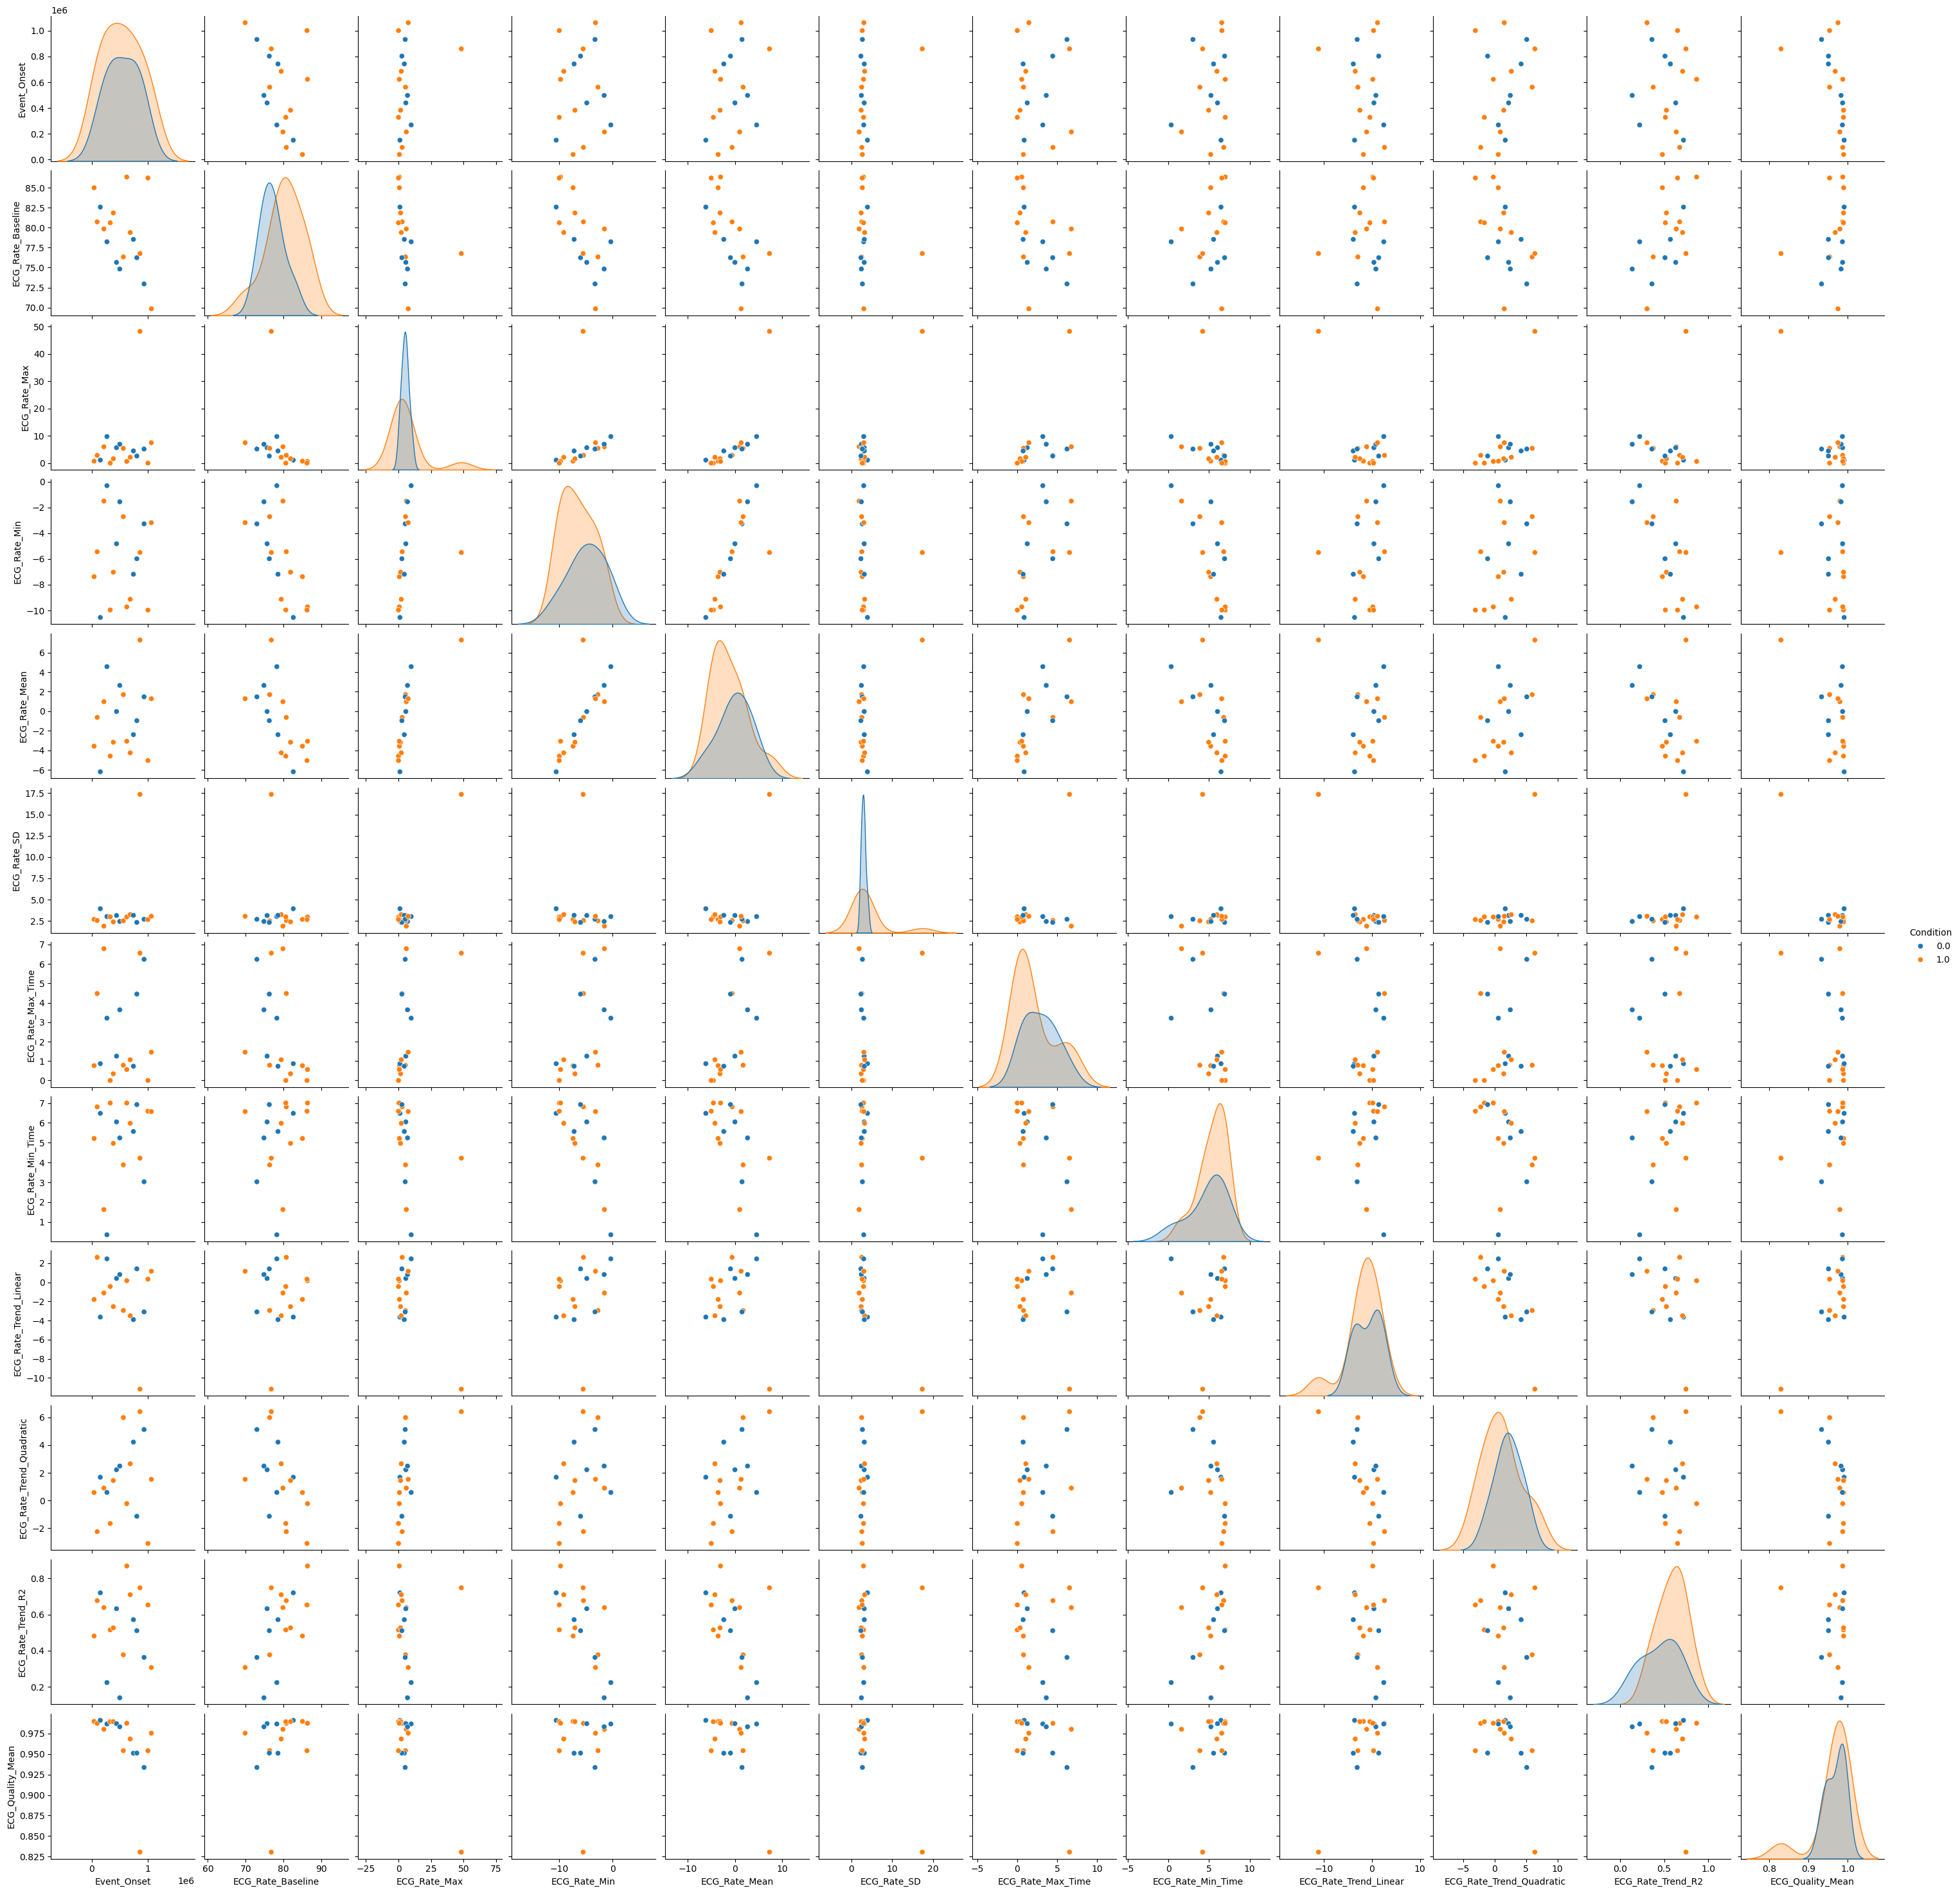

In [308]:
# show feature  grouped by trigger_values 0 and 1 using seaborn


sns.pairplot(analyze_epochs, hue='Condition')
plt.show()

In [309]:
analyze_epochs.columns

Index(['Label', 'Condition', 'Event_Onset', 'ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean'],
      dtype='object')

<Axes: xlabel='Condition', ylabel='ECG_Rate_Max'>

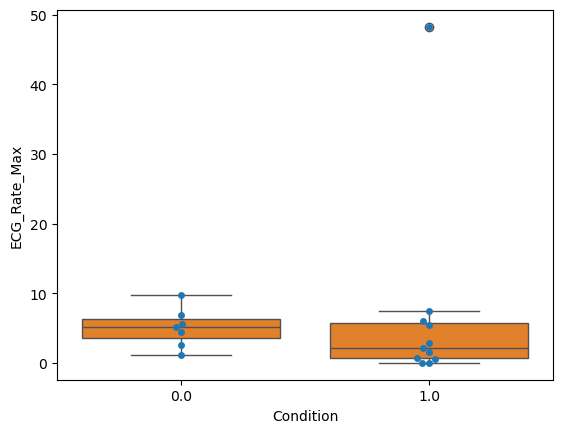

In [310]:
# show feature ECG_Rate_Baseline grouped by condition 0 and 1 using seaborn with points
#sns.swarmplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)
#sns.boxplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)



sns.swarmplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)
sns.boxplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)




In [311]:
# HRV for each epoch
epochs = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=-8.0, epochs_end=20.0)

# create variable to save HRV indices
hrv_indices = {}

for i in range(len(epochs)):
    print(f"Epoch {i}:")

    # Get the ECG_Clean signal from the epochs
    # Note: The epochs are stored in a dictionary with keys as epoch numbers
    # e.g., epochs['1'] for the first epoch, epochs['2'] for the
    # second epoch, etc.
    # You can access the ECG_Clean signal for each epoch using the key 'ECG_C

    # get data from each epoch
    # i to string
    
    ecg_cleaned = epochs[str(i+1)]['ECG_Clean']

    peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000, correct_artifacts=True)

    # Compute HRV indices
    hrv_indices[i] = nk.hrv(peaks, sampling_rate=1000)




Epoch 0:
Epoch 1:
Epoch 2:
Epoch 3:
Epoch 4:
Epoch 5:
Epoch 6:


/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correl

Epoch 7:
Epoch 8:
Epoch 9:
Epoch 10:
Epoch 11:
Epoch 12:


/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len(mse)
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/complexity/entropy_multiscale.py:349: RuntimeWarning: invalid value encountered in scalar divide
  mse = np.trapz(mse) / len

Epoch 13:
Epoch 14:
Epoch 15:
Epoch 16:
Epoch 17:


/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/bert/miniconda3/envs/coimbra_best/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correl

In [312]:
print(hrv_indices[0])
print(hrv_indices[1])


   HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  756.277778  31.95319         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN  32.702119  33.178281  ...    1.098612    4.947703   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  HRV_HFD   HRV_KFD  \
0     1.488869       0.0   0.549306    0.621227  2.092689  1.97391  3.802104   

    HRV_LZC  
0  1.292481  

[1 rows x 82 columns]
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  771.176471  31.944526         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_SampEn  HRV_ShanEn  \
0         NaN         NaN  36.943856  37.516663  ...    2.397895    4.734522   

   HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD   HRV_HFD   HRV_KFD  \
0      1.61775       0.0        0.0         0.0  1.998107  1.907591  3.214638   


# Classifier - decision tree and graph design

In [313]:
# Create array X with the features and array y with the target variable
# X = analyze_epochs[['ECG_Rate_Baseline',
#        'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
#        'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
#        'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean']]

# # Just useful features
X = analyze_epochs[['ECG_Rate_SD']]

# Add coumns to X with the EDA features
# X['EDA_Mean'] = edaMean
# X['EDA_SD'] = edaSD
# X['EDA_Max'] = edaMax
# X['EDA_Min'] = edaMin

# Added
# X['EDA_UnderCurve'] = eUnderCurve

# Add column to X with the Resp features
# X['Resp_Mean'] = rMean
# X['Resp_SD'] = rSD
X['Resp_Max'] = rMax
# X['Resp_Min'] = rMin

# Added
# X['Resp_UnderCurve'] = rUnderCurve
# X['Resp_RateVariability'] = rResp_rate_variability
# X['Resp_BreathHoldRatio'] = rBreath_hold_ratio

y = analyze_epochs['Condition']

/tmp/ipykernel_1863/4079349766.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Resp_Max'] = rMax


In [314]:

from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=3)
model.fit(X, y)

scores = cross_val_score(estimator=model,
                         X=X,
                        y=y,
                        cv=3,
                        scoring='accuracy')


print(scores, scores.mean())


[0.66666667 0.66666667 0.5       ] 0.611111111111111


In [315]:
import pickle

with open('x.pkl','wb') as f:
    pickle.dump(X,f)


with open('y.pkl','wb') as f:
    pickle.dump(y,f)

In [316]:
# X = analyze_epochs[['ECG_Rate_Baseline', 'ECG_Rate_Max']]
# used features - Resp_Max, ECG_Rate_SD
X_knn_demo = X[['Resp_Max', 'ECG_Rate_SD']]

In [317]:
X_knn_demo

,Resp_Max,ECG_Rate_SD
1,0.427170,2.665701
2,1.094487,2.537269
3,2.399222,3.923450
4,4.951409,1.875296
5,0.835702,3.000659
6,2.306746,2.964067
7,0.398602,2.370855
8,1.038272,3.124209
9,0.706174,2.424408
10,1.048963,2.497301


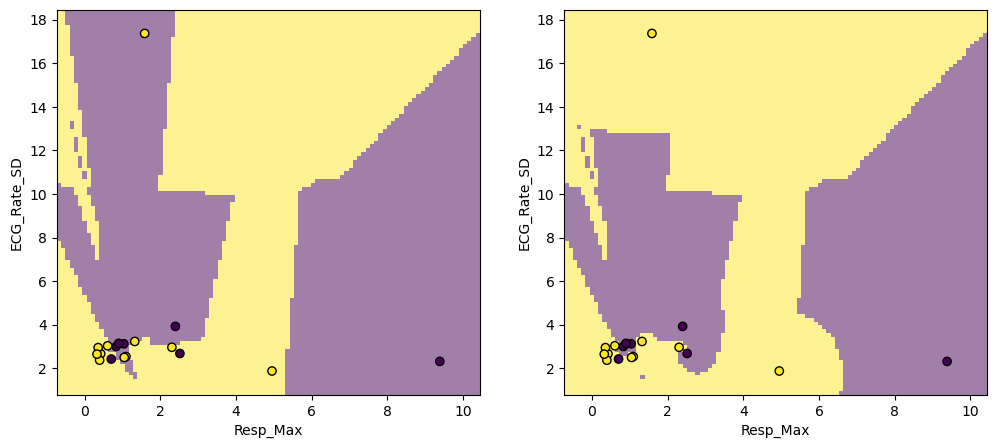

In [318]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



clf = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=5))]
)


_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    clf.set_params(knn__weights=weights).fit(X_knn_demo, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_knn_demo,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        alpha=0.5,
        ax=ax,
    )
    scatter = disp.ax_.scatter(X_knn_demo.iloc[:, 0], X_knn_demo.iloc[:, 1], c=y, edgecolors="k")



plt.show()